### Imports

In [32]:
import pandas as pd
import regex as re
from cleantext import clean
import pyarrow.feather as feather
from multiprocessing import Pool
import gc
import nltk
from nltk.util import ngrams
from nltk.corpus import words
import itertools
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import *
import time
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split    # splitting the data 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

### Loading the dataset

In [33]:
import pandas as pd
import regex as re
from cleantext import clean
data = pd.read_csv("data/sample_preprocessed_ver_2023-03-24-1679675767.csv", index_col=0)

In [34]:
# convert the strings to lists
pattern = re.compile(r"\w+")
def string_to_list(s):
    return pattern.findall(s)

In [35]:
# sperate dataframes into chunks of 10000 in order to process
# without having everything in ram at once 
chunk_size = 10000
data_chunks = [data.iloc[i:i+chunk_size] for i in range(0, data.shape[0], chunk_size)]

In [36]:
for chunk in data_chunks:
    chunk.content = chunk.content.apply(string_to_list)

/tmp/ipykernel_12260/2091772816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk.content = chunk.content.apply(string_to_list)


In [37]:
data = pd.concat(data_chunks)

In [38]:
data.head()

,level_0,index,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
0.0,0,63.0,79,awm.com,fake,http://awm.com/heres-the-video-causing-people-...,"[staff, australian, reptil, park, realiz, spid...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Here’s The Video Causing People To Gag And Run...,Alexander Smith,NaN,[''],NaN,NaN,NaN,NaN
1.0,1,79.0,97,betootaadvocate.com,fake,http://www.betootaadvocate.com/advocate-in-foc...,"[loui, burk, cultur, contact, begin, privat, c...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Turnbull Celebrates Just What It Is To Be Aust...,NaN,NaN,[''],NaN,NaN,NaN,NaN
2.0,2,296.0,348,barenakedislam.com,fake,http://barenakedislam.com/2018/01/24/michigani...,"[best, kind, muslim, student, organ, think, en...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,MICHIGANISTAN: Designated terrorist group CAIR...,"Kab Ashraf, Don Spilman, Kristi Ann, Linda Riv...",NaN,[''],NaN,NaN,NaN,NaN
3.0,3,356.0,419,familysecuritymatters.org,fake,http://www.familysecuritymatters.org/publicati...,"[islam, nation, domin, list, countri, danger, ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Family Security Matters,NaN,NaN,[''],NaN,"Islam, Religion, TAXES, SANCTUARY CITIES, Immi...",NaN,NaN
4.0,4,612.0,694,familysecuritymatters.org,fake,http://www.familysecuritymatters.org/publicati...,"[profess, christ, becom, hate, crime, west, da...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Family Security Matters,NaN,NaN,[''],NaN,"Islam, Religion, TAXES, SANCTUARY CITIES, Immi...",NaN,NaN


In [39]:
len(data)

59170

### Simple Model - Logistic Regression

In [40]:
X_train, X_val, y_train, y_val = train_test_split(data['content'], data['type'], test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer=lambda x : x, max_features=200000)
vectorizer.fit(X_train)

CountVectorizer(analyzer=<function <lambda> at 0x7f5618910700>,
                max_features=200000)

In [42]:
X_train.shape

(47336,)

In [43]:
vectorizer.get_feature_names_out()

array(['a', 'aa', 'aaa', ..., 'zzzzz', 'zzzzzz', 'zzzzzzzzz'],
      dtype=object)

In [44]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [45]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [46]:
pred = logreg.predict(X_val)

In [47]:
accuracy_score(y_val, pred)

0.7946594558053067

In [48]:
from sklearn.metrics import f1_score

# y_val er pandas series, så omdanner også til ndarray
# positive = reliable
f1_score(pd.Series.to_numpy(y_val), pred, pos_label='reliable')

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

[[480 147   0]
 [133 439   0]
 [  0   0   0]]


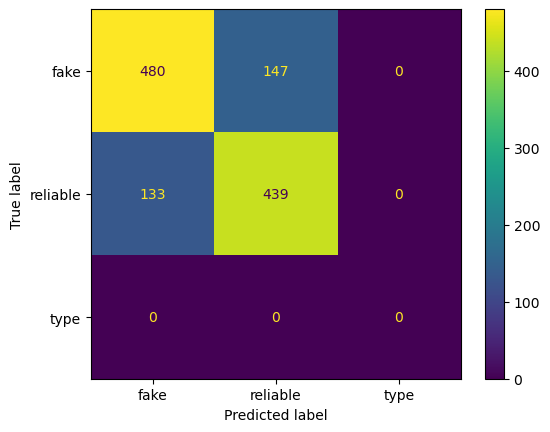

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_val), pred, labels=logreg.classes_)
print(cf_matrix)
# plotting to a heatmap
#sns.heatmap(cf_matrix, annot=True, fmt='g')
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=logreg.classes_).plot()



### Advanced Model - Naive Bayes

In [63]:
#def to_bigrams(words):
#    return list(nltk.ngrams(words, 2))

In [64]:
#chunk_size = 10000
#data_chunks = [data.iloc[i:i+chunk_size] for i in range(0, data.shape[0], chunk_size)]

In [65]:
#for chunk in data_chunks:
#    chunk['content'] = chunk['content'].apply(to_bigrams)

In [66]:
#data = pd.concat(data_chunks)

In [67]:
X_train, X_val, y_train, y_val = train_test_split(data['content'], data['type'], test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = TfidfVectorizer(analyzer=lambda x : x, max_features=50000)
vectorizer.fit(X_train)

TfidfVectorizer(analyzer=<function <lambda> at 0x7f5618a9af80>,
                max_features=50000)

In [69]:
X_train.shape

(47336,)

In [70]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [71]:
vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aac', ..., 'zynga', 'zyuganov', 'zzzzzz'],
      dtype=object)

In [72]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
nb = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
nb.fit(X_train, y_train)

SVC(gamma='auto', kernel='linear')

In [73]:
pred = nb.predict(X_val)

In [74]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, pred)

0.8195031265844178

In [75]:
from sklearn.metrics import f1_score
# y_val er pandas series, så omdanner også til ndarray
# positive = reliable
f1_score(pd.Series.to_numpy(y_val), pred, pos_label='reliable')

0.8067318132464714

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_val), pred)
print(cf_matrix)
# plotting to a heatmap
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=nb.classes_).plot()

[[2620  451]
 [ 617 2229]]


NameError: name 'ConfusionMatrixDisplay' is not defined